##### Presentation Ideas
     * AB Testing to see how the model compares in the real world. 
         * Constrained by time. Validating predictions is on the scale of years
         * Average time to default is an interesting statistic to consider
         * some kind of visual for interesting features
     * Investigate prediction probabilities
          * where was the model confidently wrong
     * Regression test: predict percentagfe defaulted to determine how much the sba should commit to
         * may be more of an inferential task

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# investiagte dropping term years to see if

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Replace with whatever model import(s) you're using
from xgboost import XGBClassifier


%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
loans = pd.read_csv("sba_loans_cleaned2.csv")
loans.info()

loans2 = pd.read_csv("data/sba_loans_cleaned3.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522582 entries, 0 to 522581
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               522582 non-null  object 
 1   BankState           522582 non-null  object 
 2   ApprovalFY          522582 non-null  int64  
 3   NoEmp               522582 non-null  int64  
 4   NewExist            522582 non-null  int64  
 5   RevLineCr           522049 non-null  float64
 6   LowDoc              518370 non-null  float64
 7   DisbursementGross   522582 non-null  float64
 8   MIS_Status          522582 non-null  int64  
 9   twoDigNAICS         522582 non-null  int64  
 10  is_franchise        522582 non-null  float64
 11  bank_out_of_state   522582 non-null  int64  
 12  Term_years          522582 non-null  float64
 13  job_category        522582 non-null  float64
 14  retained_category   522582 non-null  float64
 15  UrbanRural_cleaned  516078 non-nul

<IPython.core.display.Javascript object>

In [6]:
# loans.head()
loans2.head()

,State,BankState,ApprovalFY,NoEmp,NewExist,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,NC,MN,2006,2,1,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,0.0,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,AR,MS,2006,7,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,0.0,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,CA,SD,2006,18,1,1.0,0.0,438541.0,0,61,0.0,0,6.916667,1.0,2.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,FL,FL,2006,4,0,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,1.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,LA,LA,2006,3,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,0.0,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [7]:
cat_cols = [
    "State",
    "BankState",
    "twoDigNAICS",
]

ordinal_cols = [
    "job_category",
    "retained_category",
    "bank_size",
]

num_cols = [
    # "ApprovalFY",
    "NoEmp",
    "DisbursementGross",
    "Term_years",  # untapped potential here
    "Disbr_year",  # may want to do some grouping by or transformation
]

bin_cols = ["NewExist", "is_franchise", "bank_out_of_state", "sba_pre_approv"]

other_cols = [
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
]  # not used, just documenting all cols

# information that won't exist until a decision is made by the SBA
sba_cols = [
    "Appv_Month_sin",
    "Appv_Month_cos",
    "sba_pre_approv",
    "percent_SBA",
    "ApprovalFY",
]  # turn off for loans

# impute_cols = [
#     "RevLineCr",
#     "LowDoc",
#     "UrbanRural_cleaned",
# ]

# dropping na's until the imputer is working
loans = loans.dropna()
loans2 = loans2.dropna()

<IPython.core.display.Javascript object>

In [8]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511771 entries, 0 to 522581
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               511771 non-null  object 
 1   BankState           511771 non-null  object 
 2   ApprovalFY          511771 non-null  int64  
 3   NoEmp               511771 non-null  int64  
 4   NewExist            511771 non-null  int64  
 5   RevLineCr           511771 non-null  float64
 6   LowDoc              511771 non-null  float64
 7   DisbursementGross   511771 non-null  float64
 8   MIS_Status          511771 non-null  int64  
 9   twoDigNAICS         511771 non-null  int64  
 10  is_franchise        511771 non-null  float64
 11  bank_out_of_state   511771 non-null  int64  
 12  Term_years          511771 non-null  float64
 13  job_category        511771 non-null  float64
 14  retained_category   511771 non-null  float64
 15  UrbanRural_cleaned  511771 non-nul

<IPython.core.display.Javascript object>

In [9]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]

<IPython.core.display.Javascript object>

In [10]:
print_vif(X.select_dtypes(include="number"))

VIF results
-------------------------------
const                 814829.290183
ApprovalFY                23.479557
NoEmp                      1.031137
NewExist                   1.116096
RevLineCr                  1.637751
LowDoc                     1.463996
DisbursementGross          1.440323
twoDigNAICS                1.062718
is_franchise               1.077374
bank_out_of_state          1.552891
Term_years                 1.726284
job_category               1.142698
retained_category          1.301262
UrbanRural_cleaned         1.085572
Disbr_year                23.010926
Disbr_Month_sin            2.115029
Disbr_Month_cos            1.924876
sba_pre_approv             1.136868
bank_size                  1.762733
percent_SBA                2.268133
Appv_Month_sin             1.949872
Appv_Month_cos             2.103376
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [11]:
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


<IPython.core.display.Javascript object>

In [12]:
print_vif(X.select_dtypes(include="number"))

VIF results
-------------------------------
const                 797312.671153
NoEmp                      1.030971
NewExist                   1.115743
RevLineCr                  1.614840
LowDoc                     1.463595
DisbursementGross          1.440158
twoDigNAICS                1.062572
is_franchise               1.076743
bank_out_of_state          1.551040
Term_years                 1.705217
job_category               1.140883
retained_category          1.297471
UrbanRural_cleaned         1.085415
Disbr_year                 1.280355
Disbr_Month_sin            1.938202
Disbr_Month_cos            1.903615
sba_pre_approv             1.119391
bank_size                  1.762614
percent_SBA                2.263075
Appv_Month_sin             1.940702
Appv_Month_cos             1.891943
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [13]:
X.isna().sum()

State                 0
BankState             0
NoEmp                 0
NewExist              0
RevLineCr             0
LowDoc                0
DisbursementGross     0
twoDigNAICS           0
is_franchise          0
bank_out_of_state     0
Term_years            0
job_category          0
retained_category     0
UrbanRural_cleaned    0
Disbr_year            0
Disbr_Month_sin       0
Disbr_Month_cos       0
sba_pre_approv        0
bank_size             0
percent_SBA           0
Appv_Month_sin        0
Appv_Month_cos        0
dtype: int64

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [15]:
preprocessing = ColumnTransformer(
    [
        ("leaveOneOut", LeaveOneOutEncoder(), cat_cols),
        ("scale", StandardScaler(), num_cols),  # never hurts
        # ("knnImptute", KNNImputer(n_neighbors=2), impute_cols),
        # ("simpleImptute", SimpleImputer(), impute_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [16]:
n_trees = 100
learning_rate = 2 / n_trees

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("xgbClass", XGBClassifier(n_estimators=n_trees, learning_rate=learning_rate)),
    ]
)

<IPython.core.display.Javascript object>

In [17]:
grid = {
    "xgbClass__subsample": [0.00125,0.0025, 0.01],
    #     "gbr__max_features": [0.5, 0.75, 1.0], # alternative
    "xgbClass__colsample_bytree": [0.6, 0.8, 1.0],
    "xgbClass__max_depth": [4, 6,7,8],
}



<IPython.core.display.Javascript object>

### Gradient Boost Classifier- 1st cleaning

In [18]:
# 2.6min runtime
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=2)
pipeline_cv.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [19]:
pipeline_cv.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 6,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [20]:
pipeline_cv.score(X_train, y_train)

0.9159076461331638

<IPython.core.display.Javascript object>

In [21]:
pipeline_cv.score(X_test, y_test)

0.9149621315742167

<IPython.core.display.Javascript object>

In [22]:
y_pred = pipeline_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     96225
           1       0.88      0.76      0.82     31718

    accuracy                           0.91    127943
   macro avg       0.90      0.86      0.88    127943
weighted avg       0.91      0.91      0.91    127943



<IPython.core.display.Javascript object>

In [23]:
confusion_matrix(y_test, y_pred, normalize="true")

array([[0.96652637, 0.03347363],
       [0.24147172, 0.75852828]])

<IPython.core.display.Javascript object>

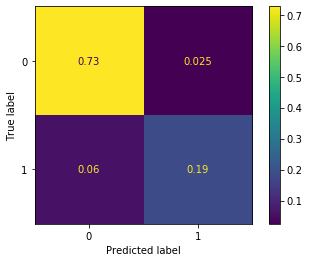

<IPython.core.display.Javascript object>

In [24]:
plot_confusion_matrix(pipeline_cv, X_test, y_test, normalize="all")

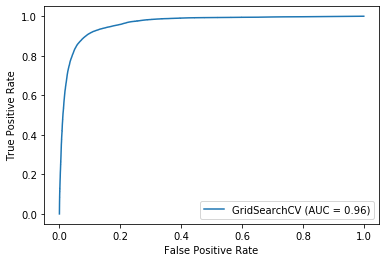

<IPython.core.display.Javascript object>

In [25]:
plot_roc_curve(pipeline_cv, X_test, y_test)

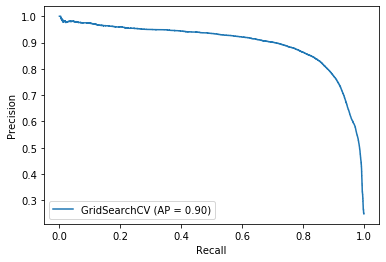

<IPython.core.display.Javascript object>

In [26]:
plot_precision_recall_curve(pipeline_cv, X_test, y_test)

In [27]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.249236
11,job_category,0.142802
18,bank_size,0.084481
1,BankState,0.082311
6,DisbursementGross,0.066173
19,percent_SBA,0.042100
8,is_franchise,0.037075
0,State,0.036943
9,bank_out_of_state,0.033857
13,UrbanRural_cleaned,0.027589


<IPython.core.display.Javascript object>

In [28]:
pd.crosstab(loans["MIS_Status"], columns=loans["bank_size"], normalize="columns")

bank_size,0.0,1.0,2.0
MIS_Status,,,
0,0.8583,0.8639,0.702774
1,0.1417,0.1361,0.297226


<IPython.core.display.Javascript object>

In [29]:
pd.crosstab(
    loans["MIS_Status"], columns=loans["bank_out_of_state"], normalize="columns"
)

bank_out_of_state,0,1
MIS_Status,,
0,0.683016,0.848945
1,0.316984,0.151055


<IPython.core.display.Javascript object>

In [30]:
pd.crosstab(loans["MIS_Status"], columns=loans["bank_size"], normalize="columns")

bank_size,0.0,1.0,2.0
MIS_Status,,,
0,0.8583,0.8639,0.702774
1,0.1417,0.1361,0.297226


<IPython.core.display.Javascript object>

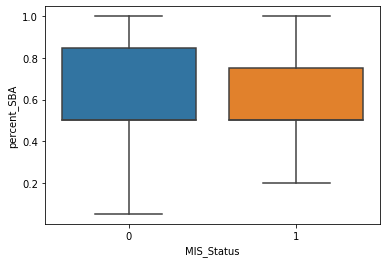

<IPython.core.display.Javascript object>

In [31]:
sns.boxplot(y="percent_SBA", x="MIS_Status", data=loans)
plt.show()

In [32]:
y.value_counts()

0    385081
1    126690
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

### Gradient Boosting Classifier: 2nd cleaning

In [33]:
loans2 = loans2.dropna()
X = loans2.drop(columns=sba_cols)
X = X.drop(columns="MIS_Status")
y = loans2["MIS_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [34]:
# 2.6min runtime
pipeline_cv_reclean = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=2)
pipeline_cv_reclean.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.4min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [35]:
pipeline_cv_reclean.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 6,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [36]:
pipeline_cv_reclean.score(X_train, y_train)

0.9094061993622916

<IPython.core.display.Javascript object>

In [37]:
pipeline_cv_reclean.score(X_test, y_test)

0.9086717892425905

<IPython.core.display.Javascript object>

In [38]:
y_pred = pipeline_cv_reclean.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     95874
           1       0.88      0.73      0.80     31666

    accuracy                           0.91    127540
   macro avg       0.90      0.85      0.87    127540
weighted avg       0.91      0.91      0.91    127540



<IPython.core.display.Javascript object>

In [39]:
confusion_matrix(y_test, y_pred, normalize="true")

array([[0.96867764, 0.03132236],
       [0.27300575, 0.72699425]])

<IPython.core.display.Javascript object>

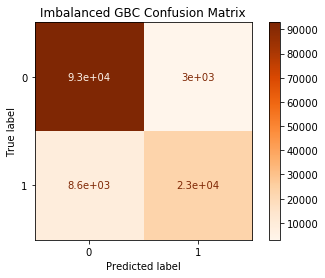

<IPython.core.display.Javascript object>

In [40]:
plot_confusion_matrix(pipeline_cv_reclean, X_test, y_test, cmap="Oranges")
plt.title("Imbalanced GBC Confusion Matrix")
plt.savefig("figs/imbalanced_cm.png")
plt.show()

In [41]:
y_test.value_counts()

0    95874
1    31666
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

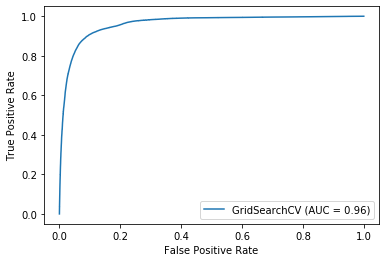

<IPython.core.display.Javascript object>

In [42]:
plot_roc_curve(pipeline_cv_reclean, X_test, y_test)

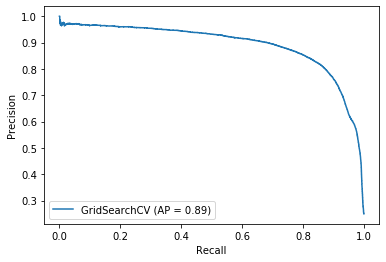

<IPython.core.display.Javascript object>

In [43]:
plot_precision_recall_curve(pipeline_cv_reclean, X_test, y_test)

In [44]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_reclean.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.267055
11,job_category,0.150737
17,bank_size,0.096859
1,BankState,0.091003
6,DisbursementGross,0.064075
9,bank_out_of_state,0.040691
0,State,0.039213
8,is_franchise,0.038292
4,RevLineCr,0.030997
3,NewExist,0.025194


<IPython.core.display.Javascript object>

That model performed comparably to just guessing 0.

Due to the large class imbalance, the majority class will be down sampled to the size of the minority class. 

### Gradient Boosting Classifier: Resampled

In [45]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()

0.5

<IPython.core.display.Javascript object>

In [46]:
pipeline_cv_resample = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=3,)
pipeline_cv_resample.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [47]:
pipeline_cv_resample.best_params_

{'xgbClass__colsample_bytree': 0.8,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [48]:
pipeline_cv_resample.score(X_train_resample, y_train_resample)

0.903735753482482

<IPython.core.display.Javascript object>

In [49]:
pipeline_cv_resample.score(X_test, y_test)

0.8893960591826048

<IPython.core.display.Javascript object>

In [50]:
y_pred = pipeline_cv_resample.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     96013
           1       0.71      0.93      0.81     31930

    accuracy                           0.89    127943
   macro avg       0.84      0.90      0.86    127943
weighted avg       0.91      0.89      0.89    127943



<IPython.core.display.Javascript object>

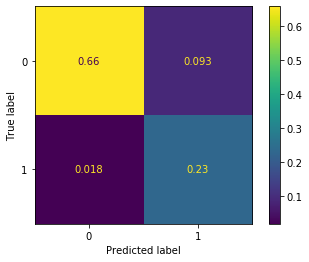

<IPython.core.display.Javascript object>

In [51]:
plot_confusion_matrix(pipeline_cv_resample, X_test, y_test, normalize="all")

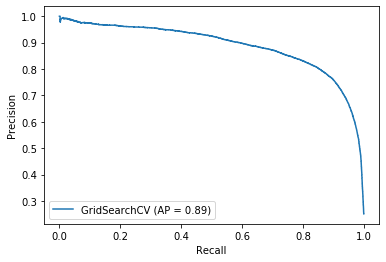

<IPython.core.display.Javascript object>

In [52]:
plot_precision_recall_curve(pipeline_cv_resample, X_test, y_test)

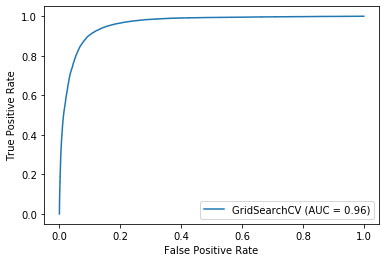

<IPython.core.display.Javascript object>

In [53]:
plot_roc_curve(pipeline_cv_resample, X_test, y_test)

In [54]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_resample.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.244231
11,job_category,0.108089
1,BankState,0.103107
6,DisbursementGross,0.057266
18,bank_size,0.055822
19,percent_SBA,0.055120
8,is_franchise,0.040601
0,State,0.038597
9,bank_out_of_state,0.032307
13,UrbanRural_cleaned,0.030926


<IPython.core.display.Javascript object>

### Gradient Boosting Classifier: 2nd Cleaning, Resample

In [55]:
loans2 = loans2.dropna()
X = loans2.drop(columns=sba_cols)
X = X.drop(columns="MIS_Status")
y = loans2["MIS_Status"]



<IPython.core.display.Javascript object>

In [56]:
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()

0.5

<IPython.core.display.Javascript object>

In [57]:
pipeline_cv_resample_reclean = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=3,)
pipeline_cv_resample_reclean.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [58]:
pipeline_cv_resample_reclean.best_params_

{'xgbClass__colsample_bytree': 0.8,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [59]:
pipeline_cv_resample_reclean.score(X_train_resample, y_train_resample)

0.903735753482482

<IPython.core.display.Javascript object>

In [60]:
pipeline_cv_resample_reclean.score(X_test, y_test)

0.8893960591826048

<IPython.core.display.Javascript object>

In [61]:
y_pred = pipeline_cv_resample_reclean.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     96013
           1       0.71      0.93      0.81     31930

    accuracy                           0.89    127943
   macro avg       0.84      0.90      0.86    127943
weighted avg       0.91      0.89      0.89    127943



<IPython.core.display.Javascript object>

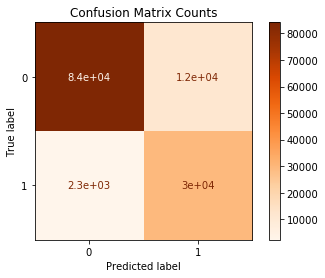

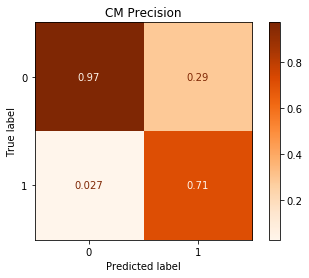

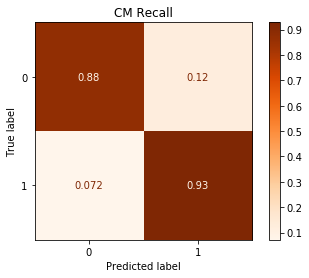

<IPython.core.display.Javascript object>

In [62]:
plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, cmap="Oranges",
)
plt.title("Confusion Matrix Counts")

plt.savefig("figs/counts_loan_pred_con_matr.png")


plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, normalize="pred", cmap="Oranges",
)
plt.title("CM Precision")

plt.savefig("figs/prec_loan_pred_con_matr.png")


plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, normalize="true", cmap="Oranges",
)
plt.title("CM Recall")

plt.savefig("figs/recall_loan_pred_con_matr.png")

plt.show()

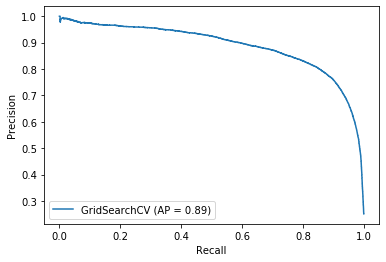

<IPython.core.display.Javascript object>

In [63]:
plot_precision_recall_curve(pipeline_cv_resample_reclean, X_test, y_test)

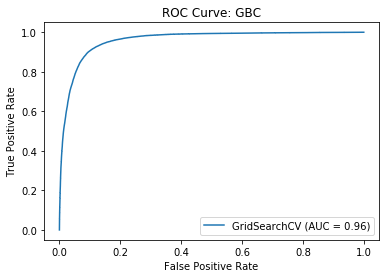

<IPython.core.display.Javascript object>

In [64]:
plot_roc_curve(pipeline_cv_resample_reclean, X_test, y_test)
plt.title("ROC Curve: GBC")
plt.show()

In [65]:
importance_df = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": pipeline_cv_resample_reclean.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("Importance", ascending=False)

,Feature,Importance
5,LowDoc,0.244231
11,job_category,0.108089
1,BankState,0.103107
6,DisbursementGross,0.057266
18,bank_size,0.055822
19,percent_SBA,0.055120
8,is_franchise,0.040601
0,State,0.038597
9,bank_out_of_state,0.032307
13,UrbanRural_cleaned,0.030926


<IPython.core.display.Javascript object>

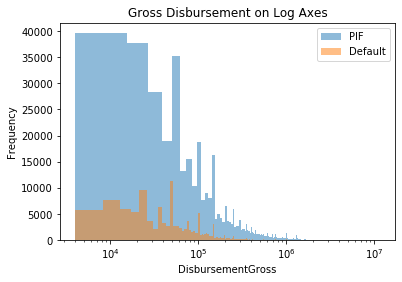

<IPython.core.display.Javascript object>

In [66]:
plt.hist(
    (loans2.loc[loans2["MIS_Status"] == 0, "DisbursementGross"]),
    alpha=0.5,
    label="PIF",
    bins=1000,
)
plt.hist(
    (loans2.loc[loans2["MIS_Status"] == 1, "DisbursementGross"]),
    alpha=0.5,
    label="Default",
    bins=1000,
)
plt.title("Gross Disbursement on Log Axes")
plt.xlabel("DisbursementGross")
plt.ylabel("Frequency")
plt.legend()
plt.xscale("log")
plt.savefig("figs/disbrgross_hists.png")
plt.show()

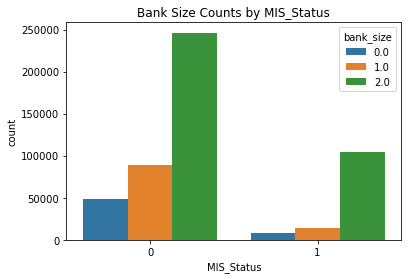

<IPython.core.display.Javascript object>

In [67]:
sns.countplot(
    x="MIS_Status", hue="bank_size", data=loans2,
)
plt.title("Bank Size Counts by MIS_Status")
# plt.savefig("figs/banksize_countplot")
plt.show()

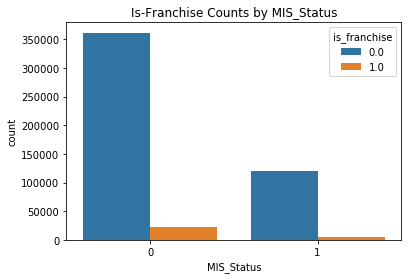

<IPython.core.display.Javascript object>

In [68]:
sns.countplot(
    x="MIS_Status", hue="is_franchise", data=loans2,
)
plt.title("Is-Franchise Counts by MIS_Status")
# plt.savefig("figs/isfranchise_countplot")
plt.show()

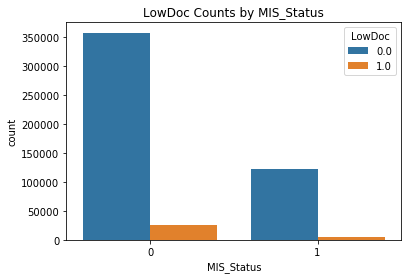

<IPython.core.display.Javascript object>

In [69]:
sns.countplot(x="MIS_Status", hue="LowDoc", data=loans2)
plt.title("LowDoc Counts by MIS_Status")
# plt.savefig("figs/lowdoc_countplot")
plt.show()

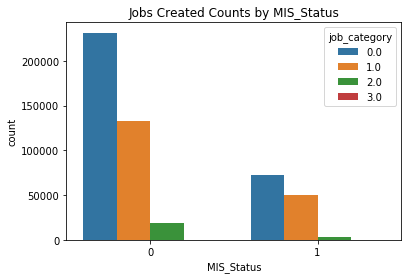

<IPython.core.display.Javascript object>

In [70]:
sns.countplot(x="MIS_Status", hue="job_category", data=loans2)
plt.title("Jobs Created Counts by MIS_Status")
# plt.savefig("figs/job_category_countplot")
plt.show()

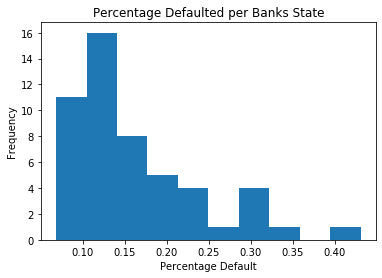

BankState
VA    0.430738
NC    0.339468
SD    0.316343
CA    0.307649
OR    0.293199
IL    0.291240
DE    0.285044
FL    0.244540
NY    0.237958
RI    0.232725
UT    0.219884
OH    0.204191
SC    0.202687
AL    0.199076
CT    0.190476
TX    0.180539
MO    0.175309
WI    0.168798
WV    0.167010
DC    0.162338
IA    0.162050
AR    0.161411
KY    0.160494
GA    0.159182
ID    0.139535
NE    0.138377
OK    0.137051
AK    0.134615
TN    0.130936
MS    0.128300
NJ    0.126822
HI    0.126208
NV    0.125000
MI    0.123644
KS    0.123408
MD    0.120241
WA    0.117607
MN    0.114859
IN    0.112768
LA    0.107488
NM    0.102632
PA    0.096965
ME    0.095610
MA    0.094795
AZ    0.089459
ND    0.083294
NH    0.082742
CO    0.076905
MT    0.069466
VT    0.069134
WY    0.068323
Name: PercentDefaulted, dtype: float64

<IPython.core.display.Javascript object>

In [71]:
bankstate_status_df = pd.crosstab(loans2["BankState"], columns=loans2["MIS_Status"])
bankstate_status_df["State"] = bankstate_status_df.index
# bankstate_status_df['Percent_Default'] =
bankstate_status_df["PercentDefaulted"] = bankstate_status_df[1] / (
    bankstate_status_df[1] + bankstate_status_df[0]
)
bankstate_status_df["PercentDefaulted"].sort_values(ascending=False)
plt.hist(bankstate_status_df["PercentDefaulted"])
plt.title("Percentage Defaulted per Banks State")
plt.xlabel("Percentage Default")
plt.ylabel("Frequency")
#plt.savefig("figs/defaulyByBankState_hist.png")
plt.show()
bankstate_status_df["PercentDefaulted"].sort_values(ascending=False)


In [72]:
loans2.groupby(by=["MIS_Status"]).agg(
    {"DisbursementGross": ["mean", "median"]}, axis="columns"
)

DisbursementGross         
                        mean   median
MIS_Status                           
0              209783.519929  87300.0
1              115712.153896  51437.0

<IPython.core.display.Javascript object>

In [73]:
loans2["job_category"].value_counts()

0.0    303902
1.0    183275
2.0     22620
3.0       363
Name: job_category, dtype: int64

<IPython.core.display.Javascript object>

In [74]:
pd.crosstab(loans["MIS_Status"], columns=loans["LowDoc"], normalize="columns")
# awarded based on cash flow!!!
# https://www.entrepreneur.com/encyclopedia/lowdoc

LowDoc,0.0,1.0
MIS_Status,,
0,0.746469,0.847128
1,0.253531,0.152872


<IPython.core.display.Javascript object>

In [75]:
pd.crosstab(loans["MIS_Status"], columns=loans["NewExist"], normalize="columns")

NewExist,0,1
MIS_Status,,
0,0.753663,0.7494
1,0.246337,0.2506


<IPython.core.display.Javascript object>

In [76]:
disbursement_job_cat = loans2.groupby(by=["LowDoc", "MIS_Status"]).agg(
    {"DisbursementGross": ["mean", "median"]}, axis="columns"
)

disbursement_job_cat

DisbursementGross         
                               mean   median
LowDoc MIS_Status                           
0.0    0              218678.793757  88599.0
       1              116630.470726  50000.0
1.0    0               86153.722524  80000.0
       1               91616.073843  90000.0

<IPython.core.display.Javascript object>

In [77]:
pd.crosstab(loans["MIS_Status"], columns=loans["is_franchise"], normalize="columns")

is_franchise,0.0,1.0
MIS_Status,,
0,0.749927,0.796707
1,0.250073,0.203293


<IPython.core.display.Javascript object>

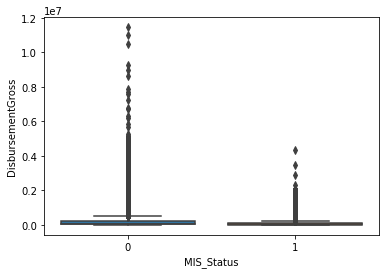

<IPython.core.display.Javascript object>

In [78]:
sns.boxplot(y="DisbursementGross", x="MIS_Status", data=loans)
plt.show()

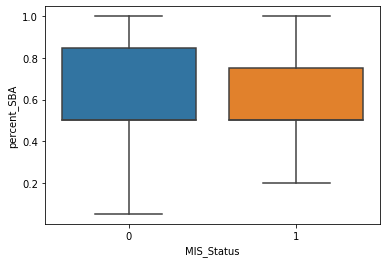

<IPython.core.display.Javascript object>

In [79]:
sns.boxplot(y="percent_SBA", x="MIS_Status", data=loans)

### Gradient Boosting Classifier: Resampled, F1 Scoring

In [80]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()


0.5

<IPython.core.display.Javascript object>

In [81]:
pipeline_cv_resample_f1 = GridSearchCV(
    pipeline, grid, verbose=1, n_jobs=-1, cv=3, scoring="f1"
)
pipeline_cv_resample_f1.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [82]:
pipeline_cv_resample_f1.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [83]:
pipeline_cv_resample_f1.score(X_train_resample, y_train_resample)

0.9073628612080703

<IPython.core.display.Javascript object>

In [84]:
pipeline_cv_resample_f1.score(X_test, y_test)

0.8062623382320684

<IPython.core.display.Javascript object>

In [85]:
y_pred = pipeline_cv_resample_f1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     96361
           1       0.71      0.93      0.81     31582

    accuracy                           0.89    127943
   macro avg       0.84      0.90      0.86    127943
weighted avg       0.91      0.89      0.89    127943



<IPython.core.display.Javascript object>

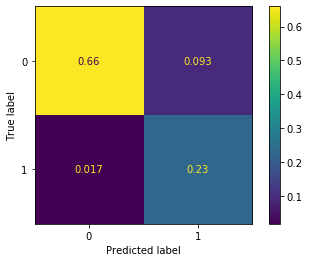

<IPython.core.display.Javascript object>

In [86]:
plot_confusion_matrix(pipeline_cv_resample_f1, X_test, y_test, normalize="all")

In [87]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_resample_f1.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.260694
11,job_category,0.119213
1,BankState,0.071285
19,percent_SBA,0.057958
6,DisbursementGross,0.050507
18,bank_size,0.050127
8,is_franchise,0.037618
0,State,0.035838
4,RevLineCr,0.031124
9,bank_out_of_state,0.028172


<IPython.core.display.Javascript object>

In [88]:
rf_grid = {
    "rf__max_depth": [4, 5, 6],
    "rf__min_samples_split": [0.1, 0.2, 0.3],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.25, 0.5, 0.75],
}

<IPython.core.display.Javascript object>

In [89]:
rf_pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('rf', RandomForestClassifier())
    ])


<IPython.core.display.Javascript object>

In [90]:
rf_cv = GridSearchCV(rf_pipeline, rf_grid, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [91]:
# rf_cv.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [92]:
# rf_cv.best_params_

<IPython.core.display.Javascript object>

In [93]:
rf_grid2 = {
    "rf__max_depth": [5],
    "rf__min_samples_split": [0.01, 0.05, 0.1, 0.2],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.7, 0.8, 0.9, 1.0],
}

<IPython.core.display.Javascript object>

In [94]:
# rf_cv2 = GridSearchCV(rf_pipeline, rf_grid2, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [95]:
# rf_cv2.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [96]:
# rf_cv2.best_params_

<IPython.core.display.Javascript object>

In [97]:
rf_grid3 = {
    "rf__max_depth": [5],
    "rf__min_samples_split": [100, 500, 1000, 10000],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.8],
}

<IPython.core.display.Javascript object>

In [98]:
rf_cv3 = GridSearchCV(rf_pipeline, rf_grid3, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [99]:
rf_cv3.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.8min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [100]:
rf_cv3.best_params_

{'rf__max_depth': 5, 'rf__max_features': 0.8, 'rf__min_samples_split': 1000}

<IPython.core.display.Javascript object>

In [101]:
rf_cv3.score(X_train, y_train)

0.8895807497108079

<IPython.core.display.Javascript object>

In [102]:
rf_cv3.score(X_test, y_test)

0.8896383545797738

<IPython.core.display.Javascript object>

In [103]:
y_pred = rf_cv3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     96361
           1       0.82      0.71      0.76     31582

    accuracy                           0.89    127943
   macro avg       0.86      0.83      0.84    127943
weighted avg       0.89      0.89      0.89    127943



<IPython.core.display.Javascript object>

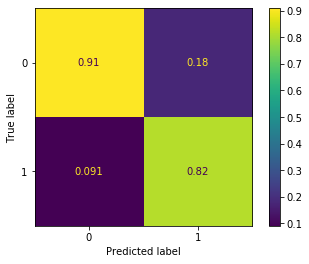

<IPython.core.display.Javascript object>

In [104]:
plot_confusion_matrix(rf_cv3, X_test, y_test, normalize="pred")

In [105]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": rf_cv3.best_estimator_.named_steps["rf"].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,8.072875e-01
1,BankState,7.797459e-02
11,job_category,4.557818e-02
6,DisbursementGross,3.795359e-02
18,bank_size,1.058565e-02
0,State,7.403453e-03
19,percent_SBA,7.147425e-03
4,RevLineCr,4.321033e-03
8,is_franchise,1.630229e-03
2,NoEmp,4.356823e-05


<IPython.core.display.Javascript object>

In [106]:
rf_grid4 = {
    "rf__max_depth": [5, 6, 7],
    "rf__min_samples_split": [1000, 2000],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.8],
}
rf_cv4 = GridSearchCV(rf_pipeline, rf_grid4, cv=2, n_jobs=-1, verbose=1)
rf_cv4.fit(X_train_resample, y_train_resample)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [107]:
rf_cv4.best_params_

{'rf__max_depth': 5, 'rf__max_features': 0.8, 'rf__min_samples_split': 1000}

<IPython.core.display.Javascript object>

In [108]:
rf_cv4.score(X_train_resample, y_train_resample)

0.8859086512175632

<IPython.core.display.Javascript object>

In [109]:
rf_cv4.score(X_test, y_test)

0.8645568729825001

<IPython.core.display.Javascript object>

In [110]:
y_pred = rf_cv4.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90     96361
           1       0.66      0.92      0.77     31582

    accuracy                           0.86    127943
   macro avg       0.82      0.88      0.84    127943
weighted avg       0.89      0.86      0.87    127943



<IPython.core.display.Javascript object>

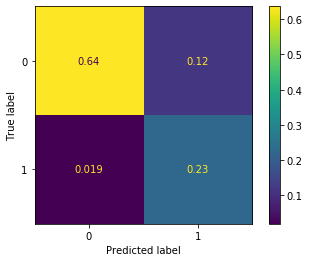

<IPython.core.display.Javascript object>

In [111]:
plot_confusion_matrix(rf_cv4, X_test, y_test, normalize="all")

In [112]:
importance_df = pd.DataFrame(
    {
        "feat": X_train_resample.columns,
        "importance": rf_cv4.best_estimator_.named_steps["rf"].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,8.529982e-01
1,BankState,5.003027e-02
11,job_category,3.648929e-02
6,DisbursementGross,2.876741e-02
19,percent_SBA,1.553012e-02
0,State,8.227141e-03
4,RevLineCr,4.314436e-03
18,bank_size,1.931995e-03
8,is_franchise,1.670478e-03
9,bank_out_of_state,1.452861e-05


<IPython.core.display.Javascript object>

In [113]:
logreg_pipe = Pipeline([("preprocessing", preprocessing), ("lr", LogisticRegression())])

<IPython.core.display.Javascript object>

In [114]:
lr_grid = {"lr__penalty": ["l2"], "lr__C": [0.01, 0.1, 1]}

<IPython.core.display.Javascript object>

In [115]:
lr_cv = GridSearchCV(logreg_pipe, lr_grid, cv=2, verbose=1, n_jobs=-1)


<IPython.core.display.Javascript object>

In [116]:
lr_cv.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.8s finished
C:\Users\dgump\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [117]:
lr_cv.best_params_

{'lr__C': 0.1, 'lr__penalty': 'l2'}

<IPython.core.display.Javascript object>

In [118]:
lr_cv.score(X_train, y_train)

0.8367497941786425

<IPython.core.display.Javascript object>

In [119]:
lr_cv.score(X_test, y_test)

0.8375526601689814

<IPython.core.display.Javascript object>

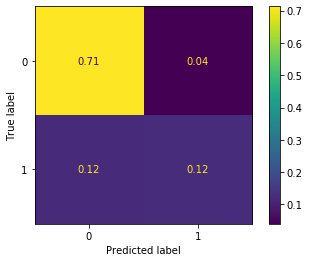

<IPython.core.display.Javascript object>

In [120]:
plot_confusion_matrix(lr_cv, X_test, y_test, normalize="all")

In [121]:
lr_cv.fit(X_train_resample, y_train_resample)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.4s finished
C:\Users\dgump\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [122]:
lr_cv.score(X_train_resample, y_train_resample)

0.8074136770828952

<IPython.core.display.Javascript object>

In [123]:
lr_cv.score(X_test, y_test)

0.7949399341894438

<IPython.core.display.Javascript object>

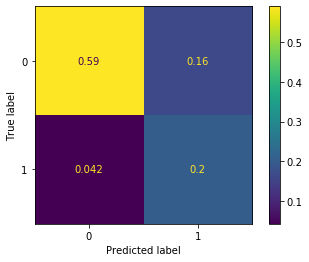

<IPython.core.display.Javascript object>

In [124]:
plot_confusion_matrix(lr_cv, X_test, y_test, normalize="all")

In [125]:
y_pred = lr_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     96361
           1       0.56      0.83      0.67     31582

    accuracy                           0.79    127943
   macro avg       0.75      0.81      0.76    127943
weighted avg       0.84      0.79      0.81    127943



<IPython.core.display.Javascript object>

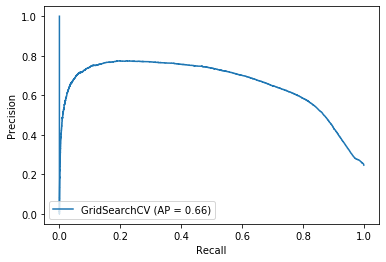

<IPython.core.display.Javascript object>

In [126]:
plot_precision_recall_curve(lr_cv, X_test, y_test)

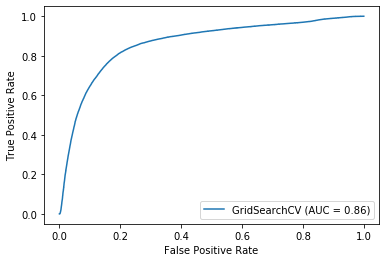

<IPython.core.display.Javascript object>

In [127]:
plot_roc_curve(lr_cv, X_test, y_test)